This is run on `chinook`. 

In [ ]:
import datetime as dt
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import dask
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib import pyplot as plt
from scipy.stats import theilslopes

In [ ]:
datadir = Path("../scripts")
fn = "snowacc_12km.nc"
datadir

PosixPath('../scripts')

In [ ]:
with xr.open_dataset(datadir / fn) as src:
    acsnow = src.acsnow
acsnow

<xarray.DataArray 'acsnow' (time: 642, south_north: 204, west_east: 264)> Size: 138MB
[34575552 values with dtype=float32]
Coordinates:
    XLONG    (south_north, west_east) float32 215kB ...
    XLAT     (south_north, west_east) float32 215kB ...
  * time     (time) datetime64[ns] 5kB 1970-01-31 1970-02-28 ... 2023-06-30
Dimensions without coordinates: south_north, west_east

In [ ]:
acsnow.groupby('time.month')[1]

<xarray.DataArray 'acsnow' (time: 54, south_north: 204, west_east: 264)> Size: 12MB
[2908224 values with dtype=float32]
Coordinates:
    XLONG    (south_north, west_east) float32 215kB ...
    XLAT     (south_north, west_east) float32 215kB ...
  * time     (time) datetime64[ns] 432B 1970-01-31 1971-01-31 ... 2023-01-31
Dimensions without coordinates: south_north, west_east

In [ ]:
monthlyclimatology = acsnow.groupby('time.month').mean()

In [ ]:
xr.apply_ufunc(
    lambda x: xr.DataArray(theilslopes(x, np.arange(len(x)))),
    acsnow.groupby('time.month')[1],
    input_core_dims=[["time"]],
    vectorize=True, 
)

<xarray.DataArray 'acsnow' (south_north: 204, west_east: 264)> Size: 431kB
array([[<xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        ...,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ],
       [<xarray.DataArray ()> Size: 8B
...
       [<xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        ...,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ,
        <xarray.DataArray ()> Size: 8B
        array(TheilslopesResult(slope=0.0, intercept=0.0, low_slope=0.0, high_slope=0.0),
              dtype=object)                                                              ]],
      dtype=object)
Coordinates:
    XLONG    (south_north, west_east) float32 215kB ...
    XLAT     (south_north, west_east) float32 215kB ...
Dimensions without coordinates: south_north, west_east

In [ ]:
from scipy.stats import theilslopes
monthstheil = {}
for month in range(1, 13):
    monthstheil[month] = xr.apply_ufunc(
        lambda x: theilslopes(x, np.arange(len(x))),
        acsnow.groupby('time.month')[month],
        input_core_dims=[["time"]],
        output_core_dims=[['time'], [], [], []],
        vectorize=True, 
    )

ValueError: 0-dimensional argument does not have enough dimensions for all core dimensions ('dim0',)

In [ ]:

monthslower = {}
monthsupper = {}
monthstheilsen = {}
for month in range(1, 13):
    monthstheilsen[month] = xr.apply_ufunc(
        lambda x: theilslopes(x, np.arange(len(x)))[0],
        acsnow.groupby('time.month')[month],
        input_core_dims=[["time"]],
        vectorize=True, parallel='dask'
    )
    monthslower[month] = xr.apply_ufunc(
        lambda x: theilslopes(x, np.arange(len(x)))[2],
        acsnow.groupby('time.month')[month],
        input_core_dims=[["time"]],
        vectorize=True
    )
    monthsupper[month] = xr.apply_ufunc(
        lambda x: theilslopes(x, np.arange(len(x)))[3],
        acsnow.groupby('time.month')[month],
        input_core_dims=[["time"]],
        vectorize=True
    )

In [ ]:
for month in range(1, 13):
    monthstheilsen[month].attrs['units'] = 'kg/m**2'

In [ ]:
monthslower_90 = {}
monthsupper_90 = {}
for month in range(1, 13):
    print(month)
    monthslower_90[month] = xr.apply_ufunc(
        lambda x: theilslopes(x, np.arange(len(x)), alpha=0.9)[2],
        acsnow.groupby('time.month')[month],
        input_core_dims=[["time"]],
        vectorize=True
    )
    monthsupper_90[month] = xr.apply_ufunc(
        lambda x: theilslopes(x, np.arange(len(x)), alpha=0.9)[3],
        acsnow.groupby('time.month')[month],
        input_core_dims=[["time"]],
        vectorize=True
    )

1
2
3
4
5
6
7
8
9
10
11
12


In [ ]:
monthsignificant_90 = {}
for month in range(1, 13):
    monthsignificant_90[month] = (
        ((monthstheilsen[month] > 0) & (monthslower_90[month] > 0)) | 
        ((monthstheilsen[month] < 0) & (monthsupper_90[month] < 0))
    )

In [ ]:
monthsignificant = {}
for month in range(1, 13):
    monthsignificant[month] = (
        ((monthstheilsen[month] > 0) & (monthslower[month] > 0)) | 
        ((monthstheilsen[month] < 0) & (monthsupper[month] < 0))
    )

In [ ]:
monthnum = 9
datetime_object = dt.datetime.strptime(str(monthnum), "%m")
month_name = datetime_object.strftime("%b")

/tmp/ipykernel_1235947/3642483683.py:1: UserWarning: "true_scale_latitude" parameter is only used for polar stereographic projections. Consider the use of "scale_factor" instead.
  projection = ccrs.Stereographic(


Text(0.5, 1.0, '1970-2023 Trend ACSNOW - Sep')

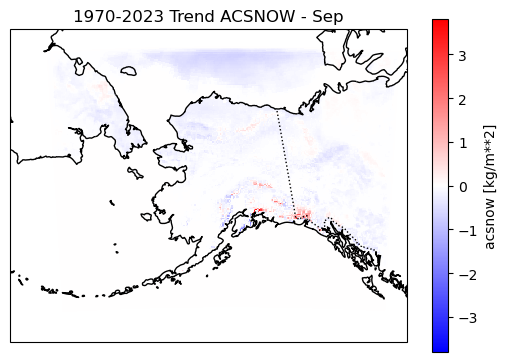

In [ ]:
projection = ccrs.Stereographic(
    central_longitude=-152.0, # central_latitude=64.0, 
    true_scale_latitude=64.0, central_latitude=64.0)

ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])

monthstheilsen[monthnum].plot(
    cmap='bwr', cbar_kwargs={"shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
    x="XLONG", y="XLAT",

)

# add additional features and corrections
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
ax.set_title(f"1970-2023 Trend ACSNOW - {month_name}")

/tmp/ipykernel_1235947/250599052.py:1: UserWarning: "true_scale_latitude" parameter is only used for polar stereographic projections. Consider the use of "scale_factor" instead.
  projection = ccrs.Stereographic(


Text(0.5, 1.0, '1970-2023 Trend ACSNOW - Sep')

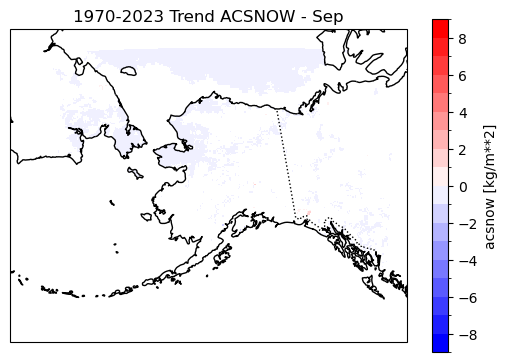

In [ ]:


projection = ccrs.Stereographic(
    central_longitude=-152.0, # central_latitude=64.0, 
    true_scale_latitude=64.0, central_latitude=64.0)

# stand_lon=-152.0, moad_cen_lat=63.99999237060547, truelat1=64.0, truelat2=None, pole_lat=90.0, pole_lon=0.0

ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])

monthstheilsen[monthnum].where(monthsignificant_90[monthnum]==1).plot(
    cmap='bwr', cbar_kwargs={"shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
    x="XLONG", y="XLAT",
    levels=19,
    vmax=9
)

# add additional features and corrections
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
ax.set_title(f"1970-2023 Trend ACSNOW - {month_name}")

In [ ]:
monthlyclimatology.attrs['units'] = 'kg/m**2'

/tmp/ipykernel_1235947/3219357271.py:1: UserWarning: "true_scale_latitude" parameter is only used for polar stereographic projections. Consider the use of "scale_factor" instead.
  projection = ccrs.Stereographic(


Text(0.5, 1.0, '1970-2023 Trend % ACSNOW - Sep')

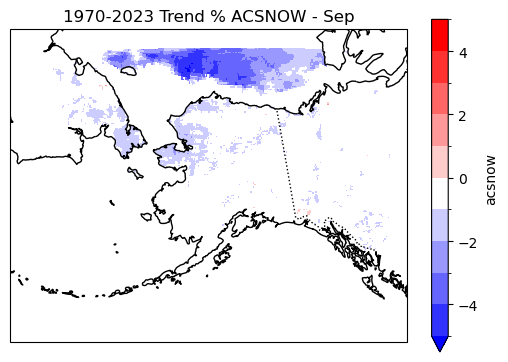

In [ ]:


projection = ccrs.Stereographic(
    central_longitude=-152.0, # central_latitude=64.0, 
    true_scale_latitude=64.0, central_latitude=64.0)


ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])

(monthstheilsen[monthnum]/monthlyclimatology[monthnum-1] * 100).where(monthsignificant_90[monthnum]==1).plot(
    cmap='bwr', cbar_kwargs={"shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
    x="XLONG", y="XLAT",
    levels=11,
    vmax=5
)

# add additional features and corrections
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
ax.set_title(f"1970-2023 Trend % ACSNOW - {month_name}")

In [ ]:
for monthnum in range(1, 13): 
    datetime_object = dt.datetime.strptime(str(monthnum), "%m")
    month_name = datetime_object.strftime("%b")
    monthstheilsen[monthnum].to_netcdf(f"acsnow_theilslope_{month_name}_12km.nc")
    monthlyclimatology[monthnum-1].to_netcdf(f"acsnow_climatology_1970_2023_{month_name}_12km.nc")
    monthsignificant_90[monthnum].to_netcdf(f"acsnow_theilsen_significance_90_{month_name}_12km.nc")
    monthsignificant[monthnum].to_netcdf(f"acsnow_theilsen_significance_95_{month_name}_12km.nc")
    